In [1]:
import igl
import pymesh
import scipy as sp
import numpy as np
from meshplot import plot, subplot, interact
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
import os
from os.path import join as pjoin

In [7]:
#mesh1 = pymesh.form_mesh(v1, f1)
mesh1 = pymesh.load_mesh(pjoin("../data/ctkDICOM-Database/demo1", "Segmentation_11_16.stl"))
mesh2 = pymesh.load_mesh(pjoin("../data/ctkDICOM-Database/demo1", "Segmentation_11_17.stl"))
mesh1.enable_connectivity()
mesh1.get_vertex_adjacent_vertices(5)

array([ 1,  3,  9, 11, 15, 18], dtype=int32)

In [8]:
def fix_mesh(mesh, detail="normal", max_vertices=20000):
    bbox_min, bbox_max = mesh.bbox
    diag_len = np.linalg.norm(bbox_max - bbox_min)
    if type(detail) == str:
        if detail == "normal":
            target_len = diag_len * 5e-3
        elif detail == "high":
            target_len = diag_len * 2.5e-3
        elif detail == "low":
            target_len = diag_len * 1e-2
    else:
        target_len = detail
    print("Target resolution: {} mm".format(target_len))
    
    tol = 0.01
    mesh, info = pymesh.remove_duplicated_vertices(mesh, target_len * tol)
    print(info)

    count = 0
    mesh, __ = pymesh.remove_degenerated_triangles(mesh, 100)
    mesh, __ = pymesh.split_long_edges(mesh, target_len)
    num_vertices = mesh.num_vertices
    while True:
        mesh, __ = pymesh.collapse_short_edges(mesh, 1e-6)
        mesh, __ = pymesh.collapse_short_edges(mesh, target_len,
                                               preserve_feature=True)
        mesh, __ = pymesh.remove_obtuse_triangles(mesh, 150.0, 100)
        if mesh.num_vertices == num_vertices or mesh.num_vertices > max_vertices:
            break

        num_vertices = mesh.num_vertices
        print("#v: {}".format(num_vertices))
        count += 1
        if count > 10: break

    mesh = pymesh.resolve_self_intersection(mesh)
    mesh, __ = pymesh.remove_duplicated_faces(mesh)
    mesh = pymesh.compute_outer_hull(mesh)
    mesh, __ = pymesh.remove_duplicated_faces(mesh)
    mesh, __ = pymesh.remove_obtuse_triangles(mesh, 179.0, 5)
    mesh, __ = pymesh.remove_isolated_vertices(mesh)

    return mesh

In [9]:
mesh1 = fix_mesh(mesh1, 0.2)
mesh2 = fix_mesh(mesh2, 0.2)

Target resolution: 0.2 mm
{'num_vertex_merged': 21, 'index_map': array([   0,    1,    2, ..., 7900, 7901, 7902], dtype=int32)}
#v: 10339
#v: 10327
Target resolution: 0.2 mm
{'num_vertex_merged': 36, 'index_map': array([   0,    1,    2, ..., 6711, 6712, 6713], dtype=int32)}
#v: 9081
#v: 9072


In [10]:
plot(mesh1.vertices, mesh1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(129.54151…

# PCA as a way to get relative axes

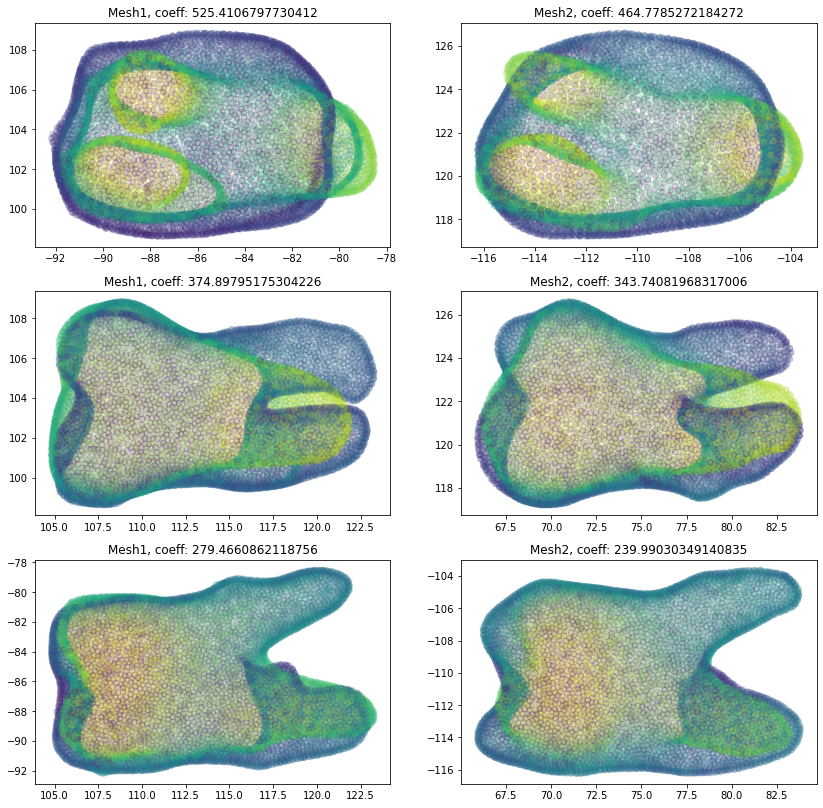

In [11]:
pca = PCA(3)
pca.fit(mesh1.vertices)
pca.components_

p1_0 = mesh1.vertices @ pca.components_[[1,2]].T
d1_0 = mesh1.vertices @ pca.components_[0]
p1_1 = mesh1.vertices @ pca.components_[[0,2]].T
d1_1 = mesh1.vertices @ pca.components_[1]
p1_2 = mesh1.vertices @ pca.components_[[0,1]].T
d1_2 = mesh1.vertices @ pca.components_[2]

pca2 = PCA(3)
pca2.fit(mesh2.vertices)
pca2.components_

p2_0 = mesh2.vertices @ pca2.components_[[1,2]].T
d2_0 = mesh2.vertices @ pca2.components_[0]
p2_1 = mesh2.vertices @ pca2.components_[[0,2]].T
d2_1 = mesh2.vertices @ pca2.components_[1]
p2_2 = mesh2.vertices @ pca2.components_[[0,1]].T
d2_2 = mesh2.vertices @ pca2.components_[2]

f, axarr = plt.subplots(3, 2, figsize = (14,14))
axarr[0,0].set_title("Mesh1, coeff: {}".format(pca.singular_values_[0]))
axarr[0,0].scatter(p1_0[:,0],p1_0[:,1], c=d1_0, alpha=0.2)
axarr[1,0].set_title("Mesh1, coeff: {}".format(pca.singular_values_[1]))
axarr[1,0].scatter(p1_1[:,0],p1_1[:,1], c=d1_1, alpha=0.2)
axarr[2,0].set_title("Mesh1, coeff: {}".format(pca.singular_values_[2]))
axarr[2,0].scatter(p1_2[:,0],p1_2[:,1], c=d1_2, alpha=0.2)

axarr[0,1].set_title("Mesh2, coeff: {}".format(pca2.singular_values_[0]))
axarr[0,1].scatter(p2_0[:,0],p2_0[:,1], c=d2_0, alpha=0.2)
axarr[1,1].set_title("Mesh2, coeff: {}".format(pca2.singular_values_[1]))
axarr[1,1].scatter(p2_1[:,0],p2_1[:,1], c=d2_1, alpha=0.2)
axarr[2,1].set_title("Mesh2, coeff: {}".format(pca2.singular_values_[2]))
axarr[2,1].scatter(p2_2[:,0],p2_2[:,1], c=d2_2, alpha=0.2)

In [12]:
norm_axis1 = pca.components_ / np.linalg.norm(pca.components_, axis=1)
norm_axis2 = pca2.components_ / np.linalg.norm(pca2.components_, axis=1)
R_pca = np.einsum("ij,ik->ijk", norm_axis1, norm_axis2).sum(0) #Rotation as in https://math.stackexchange.com/questions/1125203/finding-rotation-axis-and-angle-to-align-two-3d-vector-bases
S_pca = np.sqrt(pca2.singular_values_ / pca.singular_values_) #scale
T_pca = pca2.mean_ - pca.mean_ @ R_pca * S_pca #Translation

In [13]:
aligned_mesh1 = pymesh.form_mesh(mesh1.vertices @ R_pca * S_pca  + T_pca, mesh1.faces)

p = plot(mesh2.vertices, mesh2.faces, shading={"wireframe": True})
p.add_mesh(aligned_mesh1.vertices, mesh1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(130.47686…

1

# Trying to get automated landmarks

In [14]:
mesh1.add_attribute("vertex_mean_curvature")
mesh1.add_attribute("vertex_gaussian_curvature")
mesh1.add_attribute("vertex_area")
k = mesh1.get_attribute("vertex_mean_curvature")


p = plot(mesh1.vertices, mesh1.faces, c=k>0.5, shading={"wireframe": True})
p = plot(mesh1.vertices, mesh1.faces, c=d1_0, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(129.54151…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(129.54151…

In [15]:
def topk(x,k):
    return x.argsort()[-k:][::-1]

In [17]:
dist = 1.5
idx_concave = np.where(k > 0.5)[0]# topk(k,200)
#idx_convex = topk(-k,100)
#idx = np.concatenate([idx_concave[(np.abs(mesh1.vertices[idx_concave, 2] - mesh1.vertices[:,2].min()) < dist) | (np.abs(mesh1.vertices[idx_convex, 2] - mesh1.vertices[:,2].max()) < dist)],
#                     idx_convex[np.abs(mesh1.vertices[idx_convex, 2] - mesh1.vertices[:,2].max()) < dist]])
proj = mesh1.vertices @ pca.components_[0]
idx = idx_concave[(np.abs(proj[idx_concave] - proj.min()) < dist) | (np.abs(proj[idx_concave] - proj.max()) < dist)]

def filter_number(idx, vertices):
    d = 1.
    tree = KDTree(vertices[idx])
    inside_ball = tree.query_radius(vertices[idx], d)
    number = np.array(list(map(len, inside_ball)))
    return idx[number > 10]

idx = filter_number(idx, mesh1.vertices)

p = plot(mesh1.vertices, mesh1.faces, c=k, shading={"wireframe": True})
p.add_points(mesh1.vertices[idx], c=proj[idx], shading={"point_size": 4})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(129.54151…

1

In [18]:
p1 = np.array([1, 2, 3])
p2 = np.array([4, 6, 9])
p3 = np.array([12, 11, 9])

# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1

# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)

# Using ICL to rigidly match the teeth after a first PCA alignment

In [19]:
R, T = igl.iterative_closest_point(aligned_mesh1.vertices, mesh1.faces, mesh2.vertices, mesh2.faces, num_samples=8000, max_iters=100)

In [20]:
final_aligned_mesh1 = pymesh.form_mesh(aligned_mesh1.vertices @ R + T, mesh1.faces)

p = plot(mesh2.vertices, mesh2.faces, shading={"wireframe": True})
p.add_mesh(final_aligned_mesh1.vertices, mesh1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(130.47686…

1

# If you want to rotate along one axis

In [21]:
from scipy.linalg import expm
def Rot(axis, theta):
    return expm(np.cross(np.eye(3), axis/np.linalg.norm(axis)*np.pi*theta/180))

axis = PCA(3).fit(final_aligned_mesh1.vertices).components_[0]
center = PCA(3).fit(final_aligned_mesh1.vertices).mean_
R2 = Rot(axis, 180)

p = plot(mesh2.vertices, mesh2.faces, shading={"wireframe": True})
p.add_mesh((final_aligned_mesh1.vertices - center) @ R2 + center, mesh1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(130.47686…

1

I'm pretty sure we should look at SIFt features on 3D meshes:
http://yosi-keller.narod.ru/publications/pdf/mesh_descriptors_two_columns_final.pdf
and the code :
https://github.com/talda/ldsift

This allow to find landmarks so we could do rigid transformation with landmarks + use it after for non-rigid transformation

# Non-rigid deformation using optimization of a cost function

In [22]:
def check_angle(vec1,vec2,threshAngle):
    if (len(vec1) == 0 or len(vec2) == 0):
        return np.ones((vec2.shape[0],1))

    crossProd = np.cross(vec1,vec2,1)
    dotProd = np.sum((vec1*vec2),1)
    angle = np.arctan2((np.sum((crossProd**2),1))**0.5, dotProd)/np.pi*180

    angle = angle%360

    return angle <= threshAngle

In [23]:
def cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, AM=None, NN_M2S=None, dist=None, is_valid_nn=None):
    N = M.num_vertices
    A = A.reshape(3,4,N)
    
    #if AM is None:
    AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",A, M.vertices.T), M.faces)
    #if (dist is None and is_valid_nn is None) or NN_M2S is None:
    tree = KDTree(S.vertices, leaf_size=40)
    dist, NN_M2S = tree.query(AM.vertices,1)
    NN_M2S = NN_M2S.flatten()
    dist = dist.flatten()
    #if is_valid_nn is None:
    AMn = igl.per_vertex_normals(AM.vertices, M.faces)
    Sn = igl.per_vertex_normals(S.vertices, S.faces)
    is_valid_nn = check_angle(AMn, Sn[NN_M2S], 60) & (dist <= dist_min)

    E_smooth = 0
    nSmooth = 0
    for i in range(N):
        ring = M.get_vertex_adjacent_vertices(i)
        E_smooth += (np.linalg.norm(A[:,:,i:i+1] - A[:,:,ring])**2).sum()
        nSmooth += len(ring)
    E_smooth *= W_smooth/nSmooth

    if W_data > 0 and np.sum(is_valid_nn) > 0:
        E_data = (is_valid_nn/np.sum(is_valid_nn) * np.linalg.norm(AM.vertices - S.vertices[NN_M2S])**2).sum()
    else:
        E_data = 0.

    E_lm = (np.linalg.norm(np.einsum("ijk,jk->ki",A[:,:,landmarks_M], M.vertices[landmarks_M].T) - S.vertices[landmarks_S])**2).sum()
    if (len(landmarks_M) > 0):
        E_lm *= W_lm/len(landmarks_M)

    E_total = E_data + E_smooth + E_lm

    return E_total

def grad_cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, AM=None, NN_M2S=None, dist=None, is_valid_nn=None):
    N = M.num_vertices
    A = A.reshape(3,4,N)
    
    #if AM is None:
    AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",A, M.vertices.T), M.faces)
    #if (dist is None and is_valid_nn is None) or NN_M2S is None:
    tree = KDTree(S.vertices, leaf_size=40)
    dist, NN_M2S = tree.query(AM.vertices,1)
    NN_M2S = NN_M2S.flatten()
    dist = dist.flatten()
    #if is_valid_nn is None:
    AMn = igl.per_vertex_normals(AM.vertices, M.faces)
    Sn = igl.per_vertex_normals(S.vertices, S.faces)
    is_valid_nn = check_angle(AMn, Sn[NN_M2S], 60) & (dist <= dist_min)

    G_data = 0
    if W_data > 0 and np.sum(is_valid_nn) > 0:
        G_data = W_data * is_valid_nn/np.sum(is_valid_nn) * 2 * np.einsum("ki,kj->jik", M.vertices, AM.vertices - S.vertices[NN_M2S])
    
    G_smooth = np.zeros((3,4,N))
    nSmooth = 0
    for i in range(N):
        ring = M.get_vertex_adjacent_vertices(i)
        G_smooth[:,:,i] += 2*(A[:,:,i:i+1] - A[:,:,ring]).sum(2)
        nSmooth += len(ring)
    G_smooth *= W_smooth/nSmooth

    G_lm = np.zeros((3,4,N))
    G_lm[:,:,landmarks_M] = 2 * np.einsum("ki,kj->jik", M.vertices[landmarks_M], np.einsum("ijk,jk->ki",A[:,:,landmarks_M], M.vertices[landmarks_M].T) - S.vertices[landmarks_S])
    if (len(landmarks_M) > 0):
        G_lm *= W_lm/len(landmarks_M)

    G = G_lm + G_smooth + G_data
    G = G.reshape([3*4*N,1])
    return G

In [24]:
W_data = 1
W_smooth = 1e+6
W_lm = 1e-3
dist_min = 0.4
A = np.array([np.concatenate([np.identity(3), np.zeros((3,1))],1) + 0.01*(2*np.random.random()-1) for _ in range(mesh1.num_vertices)]).transpose(1,2,0)

S = pymesh.form_mesh(mesh2.vertices - mesh2.vertices.mean(0), mesh2.faces)
M = pymesh.form_mesh(np.concatenate([final_aligned_mesh1.vertices - mesh2.vertices.mean(0), np.ones((mesh1.num_vertices,1))], 1), mesh1.faces)
M.enable_connectivity()

landmarks_M = []
landmarks_S = []

In [25]:
cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min)

1945.0678495758993

In [26]:
grad_cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min)

array([[ 0.26066884],
       [-0.83518493],
       [-1.6555118 ],
       ...,
       [-0.90818248],
       [-0.763593  ],
       [-0.46358478]])

In [27]:
from scipy.optimize import minimize, fmin_l_bfgs_b

W_data = 1
W_smooth = 1e+6
W_lm = 1e-3
dist_min = 0.4
A = np.array([np.concatenate([np.identity(3), [[0],[0],[0]]],1) + 0.01*(2*np.random.random()-1) for _ in range(mesh1.num_vertices)]).transpose(1,2,0)

fun_args = (M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min)

it = 1
maxiter = 400
errPrev = np.inf
err = 1e9
eps_err = 1e-3

while (np.abs(errPrev - err) > eps_err and W_smooth >= W_data*1e3 and it <= maxiter):  
    errPrev = err
    A, err, _ = fmin_l_bfgs_b(cost_fun, A, grad_cost_fun, args=fun_args, maxiter=1)
    
    A = A.reshape(3,4,mesh1.num_vertices)

    AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",A, M.vertices.T), M.faces)
    tree = KDTree(S.vertices, leaf_size=40)
    dist, NN_M2S = tree.query(AM.vertices,1)
    NN_M2S = NN_M2S.flatten()
    dist = dist.flatten()
    AMn = igl.per_vertex_normals(AM.vertices, M.faces)
    Sn = igl.per_vertex_normals(S.vertices, S.faces)
    is_valid_nn = check_angle(AMn, Sn[NN_M2S], 60) & (dist <= dist_min)
    
    dist = np.linalg.norm(AM.vertices - S.vertices[NN_M2S])**2
    distAll = (dist * is_valid_nn).sum()
    
    W_smooth *= 0.75
    W_lm *= 0.75
    fun_args = (M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, AM, NN_M2S, dist, is_valid_nn)
    
    print('{} ERR: {} %_valid_nn: {} Dist: {}'.format(it, err, np.sum(is_valid_nn) / len(is_valid_nn), distAll))
    it += 1

1 ERR: 1313.0954252019967 %_valid_nn: 0.7714168039538715 Dist: 8532315.50415331
2 ERR: 1159.402118953051 %_valid_nn: 0.7741968698517299 Dist: 8539146.972554551
3 ERR: 1143.2199450380813 %_valid_nn: 0.7750205930807249 Dist: 8545226.872007886
4 ERR: 1138.9198853842115 %_valid_nn: 0.7747116968698518 Dist: 8540534.499611342
5 ERR: 1136.893059763109 %_valid_nn: 0.7750205930807249 Dist: 8542818.626581728
6 ERR: 1135.6360445195003 %_valid_nn: 0.7741968698517299 Dist: 8532207.02153284
7 ERR: 1134.6418494305817 %_valid_nn: 0.7747116968698518 Dist: 8534828.087374125
8 ERR: 1133.1244959237838 %_valid_nn: 0.7754324546952224 Dist: 8532998.809752772
9 ERR: 1132.9506377989353 %_valid_nn: 0.7754324546952224 Dist: 8531919.518803746
10 ERR: 1132.1431139562799 %_valid_nn: 0.7755354200988468 Dist: 8527106.546352906
11 ERR: 1131.5084818261391 %_valid_nn: 0.7757413509060955 Dist: 8524663.64697999
12 ERR: 1130.1490578199007 %_valid_nn: 0.77584431630972 Dist: 8515595.323954623
13 ERR: 1129.0641654808019 %_val

After the first optimization with decreasing weights for landmarks and smoothness regularization, we continue with fixed weights

In [28]:
it = 1
def callbackF(A, *args):
    global it
    print(it, cost_fun(A, *fun_args))
    it += 1

fun_args = (M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min)
res = minimize(cost_fun, A, args=fun_args, method='L-BFGS-B', jac=grad_cost_fun, callback=callbackF, options={'maxiter':400, 'disp':True})

1 939.1305966642441
2 903.9005584169987
3 670.505906155873
4 668.8405190751049
5 666.8745361503926
6 641.5796756133775
7 626.8064344834557
8 606.0683145827859
9 578.4835577265283
10 546.664099450614
11 512.3302734762414
12 486.9117279683544
13 464.95537398974295
14 444.10843699741486
15 424.5944062899111
16 409.9653565110895
17 396.23493424916427
18 381.3342760006694
19 371.63064237622126
20 359.3523409280493
21 349.4543776099005
22 339.4275847570333
23 332.1653159381279
24 324.3775532721495
25 317.2570319222734
26 310.91873862160264
27 304.1134698423503
28 298.49869769
29 294.0995569882179
30 290.99527697891057
31 288.58379076498966
32 285.43616222859634
33 283.10319183705514
34 279.79530343750884
35 276.564414440193
36 274.09891037094116
37 272.1095974755932
38 271.22257341582184
39 269.1693162899957
40 266.796010339138
41 264.97965237137817
42 262.65824709004147
43 261.24385225253843
44 260.26704700957947
45 258.28386217109716
46 254.65801072812323
47 253.36605036543463
48 250.15310

In [29]:
comp_A = res.x.reshape(3,4,mesh1.num_vertices)
comp_A[:,:,0]

array([[ 1.00964567e+00, -5.16459701e-03, -1.12857671e-02,
        -1.34430413e-03],
       [ 1.47353387e-03,  1.00016362e+00, -3.78011530e-03,
        -4.85854243e-04],
       [ 2.92205863e-03,  1.70595493e-03,  9.97487991e-01,
         3.45462565e-05]])

In [30]:
AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",comp_A, M.vertices.T), M.faces)
tree = KDTree(S.vertices, leaf_size=40)
dist, NN_M2S = tree.query(AM.vertices,1)
NN_M2S = NN_M2S.flatten()
dist = dist.flatten()
AMn = igl.per_vertex_normals(AM.vertices, M.faces)
Sn = igl.per_vertex_normals(S.vertices, S.faces)
is_valid_nn = check_angle(AMn, Sn[NN_M2S], 60) & (dist <= dist_min)
print(is_valid_nn.sum()/len(is_valid_nn))
plot(AM.vertices, mesh1.faces, c=is_valid_nn, shading={"wireframe": True})

0.9836285008237232


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.909275…

In [31]:
displacement = ((AM.vertices - M.vertices[:,:3])**2).sum(1)

In [32]:
tree = KDTree(AM.vertices, leaf_size=40)
dist, NN_S2M = tree.query(S.vertices[:,:3],1)
NN_S2M = NN_S2M.flatten()
dist = dist.flatten()
np.linalg.norm(AM.vertices[NN_S2M] - S.vertices, 'fro')

13.403204740041959

In [33]:
# Plot the deformed mesh1
plot(AM.vertices, mesh1.faces, c=displacement, shading={"wireframe": True})
# Plot the mesh2 with distance to NN error as color
plot(mesh2.vertices, mesh2.faces, c=dist, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.909275…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(130.47686…

In [34]:
p = plot(S.vertices[:,:3], mesh2.faces, shading={"wireframe": True})
p.add_mesh(AM.vertices, AM.faces, c=np.array([(0.7,0.7,0.7)]*AM.num_vertices), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.118390…

1

# Row

In [151]:
row1 = pymesh.merge_meshes([pymesh.load_mesh(pjoin("data/ctkDICOM-Database/demo1", "Segmentation_11_{}{}.stl".format(j,i))) for i in range(1,8)for j in [1,2]])
row2 = pymesh.merge_meshes([pymesh.load_mesh(pjoin("data/ctkDICOM-Database/demo1", "Segmentation_11_{}{}.stl".format(j,i))) for i in range(1,8)for j in [3,4]])
row1 = fix_mesh(row1)
row2 = fix_mesh(row2)

Target resolution: 0.3999128021359737 mm
{'num_vertex_merged': 188, 'index_map': array([    0,     1,     2, ..., 73773, 73774, 73775], dtype=int32)}
#v: 23834
#v: 23798
Target resolution: 0.4038898754828206 mm
{'num_vertex_merged': 202, 'index_map': array([    0,     1,     2, ..., 63295, 63296, 63297], dtype=int32)}
#v: 20217
#v: 20182


In [152]:
p = plot(row1.vertices, row1.faces, shading={"wireframe": True})
p.add_mesh(row2.vertices, row2.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(108.35115…

1

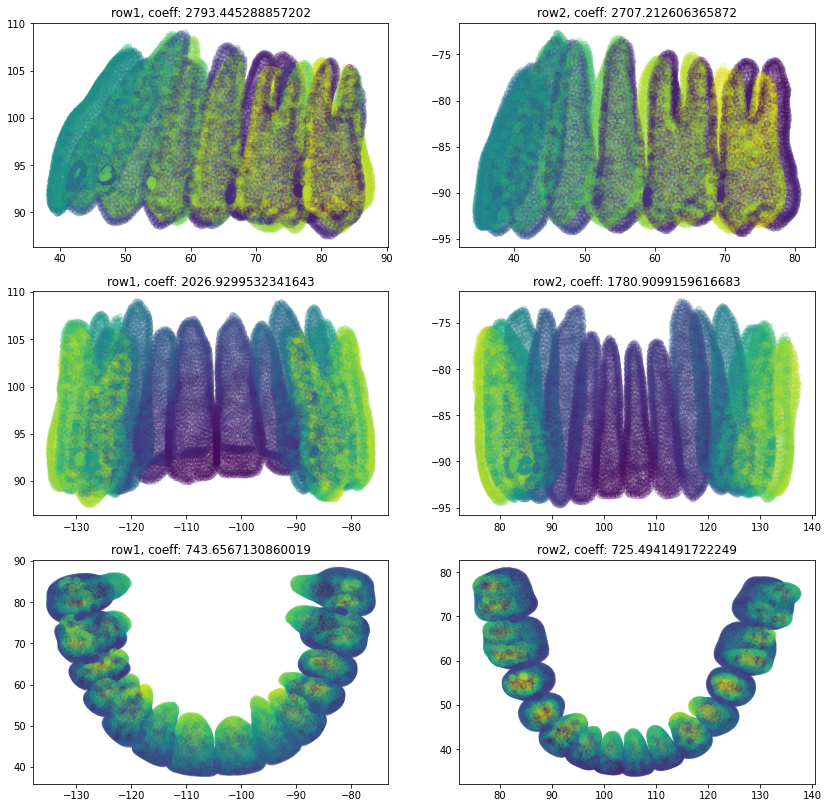

In [153]:
pca = PCA(3)
pca.fit(row1.vertices)
pca.components_

p1_0 = row1.vertices @ pca.components_[[1,2]].T
d1_0 = row1.vertices @ pca.components_[0]
p1_1 = row1.vertices @ pca.components_[[0,2]].T
d1_1 = row1.vertices @ pca.components_[1]
p1_2 = row1.vertices @ pca.components_[[0,1]].T
d1_2 = row1.vertices @ pca.components_[2]

pca2 = PCA(3)
pca2.fit(row2.vertices)
pca2.components_

p2_0 = row2.vertices @ pca2.components_[[1,2]].T
d2_0 = row2.vertices @ pca2.components_[0]
p2_1 = row2.vertices @ pca2.components_[[0,2]].T
d2_1 = row2.vertices @ pca2.components_[1]
p2_2 = row2.vertices @ pca2.components_[[0,1]].T
d2_2 = row2.vertices @ pca2.components_[2]

f, axarr = plt.subplots(3, 2, figsize = (14,14))
axarr[0,0].set_title("row1, coeff: {}".format(pca.singular_values_[0]))
axarr[0,0].scatter(p1_0[:,0],p1_0[:,1], c=d1_0, alpha=0.2)
axarr[1,0].set_title("row1, coeff: {}".format(pca.singular_values_[1]))
axarr[1,0].scatter(p1_1[:,0],p1_1[:,1], c=d1_1, alpha=0.2)
axarr[2,0].set_title("row1, coeff: {}".format(pca.singular_values_[2]))
axarr[2,0].scatter(p1_2[:,0],p1_2[:,1], c=d1_2, alpha=0.2)

axarr[0,1].set_title("row2, coeff: {}".format(pca2.singular_values_[0]))
axarr[0,1].scatter(p2_0[:,0],p2_0[:,1], c=d2_0, alpha=0.2)
axarr[1,1].set_title("row2, coeff: {}".format(pca2.singular_values_[1]))
axarr[1,1].scatter(p2_1[:,0],p2_1[:,1], c=d2_1, alpha=0.2)
axarr[2,1].set_title("row2, coeff: {}".format(pca2.singular_values_[2]))
axarr[2,1].scatter(p2_2[:,0],p2_2[:,1], c=d2_2, alpha=0.2)

In [154]:
T_row_pca = pca2.mean_ - pca.mean_ #Translation
norm_axis1 = pca.components_ / np.linalg.norm(pca.components_, axis=1)
norm_axis2 = pca2.components_ / np.linalg.norm(pca2.components_, axis=1)
R_row_pca = np.einsum("ij,ik->ijk", norm_axis2, norm_axis1).sum(0) #Rotation as in https://math.stackexchange.com/questions/1125203/finding-rotation-axis-and-angle-to-align-two-3d-vector-bases
S_row_pca = np.sqrt(pca2.singular_values_ / pca.singular_values_) #scale

In [155]:
aligned_row1 = pymesh.form_mesh((row1.vertices - pca.mean_) @ R_row_pca * S_row_pca + pca.mean_ + T_row_pca, row1.faces)

p = plot(row2.vertices, row2.faces, shading={"wireframe": True})
p.add_mesh(aligned_row1.vertices, row1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(108.13010…

1

In [6]:
test = pymesh.load_mesh(pjoin("../data/ctkDICOM-Database/demo1", "Segmentation_11_16.stl"))
test = fix_mesh(test, 0.2)
plot(test.vertices, test.faces, shading={"wireframe": True})

Target resolution: 0.2 mm
{'num_vertex_merged': 21, 'index_map': array([   0,    1,    2, ..., 7900, 7901, 7902], dtype=int32)}
#v: 10339
#v: 10327


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(129.54151…